In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, vmap 

In [ ]:
@jit
def T(eps,T_params):

    gamma_L = T_params[0]
    gamma_R = T_params[1]
    eps_L = T_params[2]
    eps_R = T_params[3]

    return (gamma_L*gamma_R/((eps-eps_L)**2 + 0.25*(gamma_R + gamma_L)**2))

In [ ]:
T_params = [0.5,0.5,1.,1.,5.] # [gamma_L, gamma_R, eps_L, eps_R, omega] 
e_axis = jnp.linspace(-100,100,20001) 
v_T = vmap(T,(0,None))

In [ ]:
out_1 = v_T(e_axis, T_params) 

In [ ]:
jnp.shape(out_1)

(20001,)

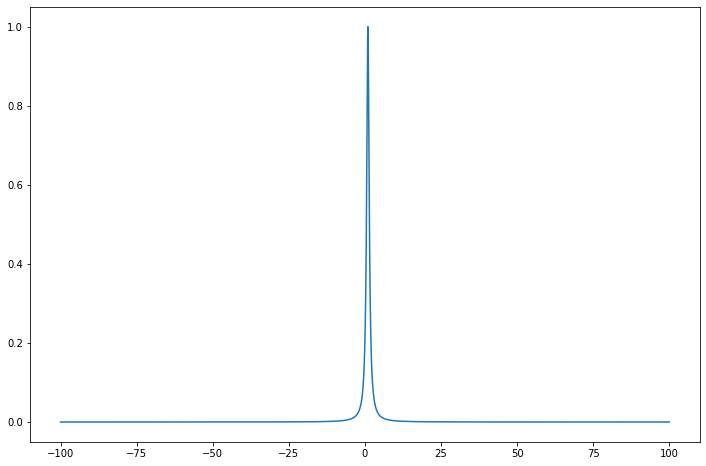

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(e_axis,out_1)
plt.show()

In [ ]:
@jit
def T2(eps,T_params):

    gamma_L = T_params[0]
    gamma_R = T_params[1]
    eps_L = T_params[2]
    eps_R = T_params[3]
    omega = T_params[4]
    a = eps - eps_L
    b = gamma_L/2
    c = eps - eps_R
    d = gamma_R/2

    return (((gamma_L)*(gamma_R)*(omega**2))/(((a*c - b*d - (omega**2))**2) + ((a*d + b*c)**2))) 

In [ ]:
v_T2 = vmap(T2,(0,None))
out_2 = v_T2(e_axis, T_params) 

In [ ]:
jnp.shape(out_2)

(20001,)

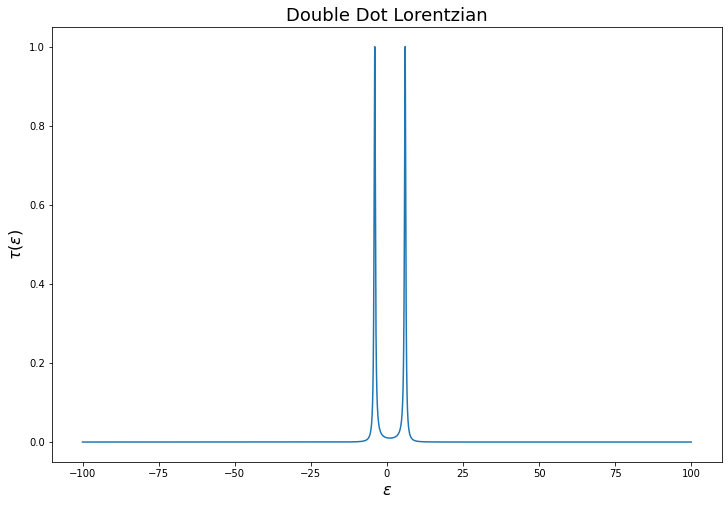

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(e_axis,out_2)
ax.set_title("Double Dot Lorentzian",fontsize=18)
ax.set_ylabel(r'$\tau (\epsilon)$',fontsize=16)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
# plt.savefig("Lorentzian_DD.png",dpi=500)
plt.show()

In [ ]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import value_and_grad
from jax.experimental import optimizers
from jax import jit, vmap

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import sys, getopt

# general 
INFTY = 100
integration_pts = 80001

In [ ]:
@jit
def f_FD(eps,f_params): # (mu, beta)
    mu = f_params[0]
    beta = f_params[1]
    
    return (1 + jnp.exp(beta*(eps-mu)))**-1

In [ ]:
@jit
def T(eps,T_params): # (gamma_L, gamma_R, eps_d)
    gamma_L = T_params[0]
    gamma_R = T_params[1]
    eps_d = T_params[2]
    return (gamma_L*gamma_R/((eps-eps_d)**2 + 0.25*(gamma_R+gamma_L)**2))

@jit
def T2(eps,T2_params): # T2_params: [gamma_L, gamma_R, eps_L, eps_R, omega] (reasonably, [0.05,0.05,4,4,10])

    gamma_L = T2_params[0]
    gamma_R = T2_params[1]
    eps_L = T2_params[2]
    eps_R = T2_params[3]
    omega = T2_params[4]
    a = eps - eps_L
    b = gamma_L/2
    c = eps - eps_R
    d = gamma_R/2

    return (((gamma_L)*(gamma_R)*(omega**2))/(((a*c - b*d - (omega**2))**2) + ((a*d + b*c)**2))) 

In [ ]:
v_f_FD = vmap(f_FD,(0,None))
v_T = vmap(T,(0,None))
v_T2 = vmap(T2,(0,None)) 

In [ ]:
@jit
def j_c(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])
    res = jnp.sum(v_T(e_axis,T_params)*(v_f_FD(e_axis,f_params_L)-v_f_FD(e_axis,f_params_R)))*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def j_c2(params2): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    T2_params = (params2[2], params2[3], params2[6], params2[7], params2[8])
    res = jnp.sum(v_T2(e_axis,T2_params)*(v_f_FD(e_axis,f_params_L)-v_f_FD(e_axis,f_params_R)))*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def j_E(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])
    res = jnp.sum(e_axis*v_T(e_axis,T_params)*(v_f_FD(e_axis,f_params_L)-v_f_FD(e_axis,f_params_R)))*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def eta_1(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    mu_L = params[0]
    mu_R = params[1]
    beta_L = params[4]
    beta_R = params[5]
    avg_jc = j_c(params)
    avg_jE = j_E(params)
    return (mu_L-mu_R)*avg_jc/(avg_jE-mu_R*avg_jc)

@jit
def noise_j_c(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])
    res = jnp.sum(v_T(e_axis,T_params)*(f_FD(e_axis,f_params_L)+f_FD(e_axis,f_params_R)- \
             2*f_FD(e_axis,f_params_L)*f_FD(e_axis,f_params_R)- \
             v_T(e_axis,T_params)*(f_FD(e_axis,f_params_L)-f_FD(e_axis,f_params_R))**2))* \
                 (e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def noise_j_c2(params2): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    T2_params = (params2[2], params2[3], params2[6], params2[7], params2[8])
    res = jnp.sum(v_T2(e_axis,T2_params)*(f_FD(e_axis,f_params_L)+f_FD(e_axis,f_params_R)- \
             2*f_FD(e_axis,f_params_L)*f_FD(e_axis,f_params_R)- \
             v_T2(e_axis,T2_params)*(f_FD(e_axis,f_params_L)-f_FD(e_axis,f_params_R))**2))* \
                 (e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def noise_j_E(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])
    res = jnp.sum(e_axis**2*v_T(e_axis,T_params)*(v_f_FD(e_axis,f_params_L)+v_f_FD(e_axis,f_params_R)- \
             2*v_f_FD(e_axis,f_params_L)*v_f_FD(e_axis,f_params_R)- \
             v_T(e_axis,T_params)*(v_f_FD(e_axis,f_params_L)-v_f_FD(e_axis,f_params_R))**2))* \
                 (e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def j_c_pow3(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])

    T = v_T(e_axis,T_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = (-2*(T**3)*(( fL*(fR - 1) - fR*(fL - 1) )**3) )
    B = (-3*(T**2)*(fL*(fR - 1) + fR*(fL - 1))*(fL*(fR - 1) - fR*(fL - 1)) )
    C = (-(fL*(fR - 1) - fR*(fL - 1))*T )

    res = jnp.sum(A + B + C)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)

    return res

@jit
def j_c_pow3_2(params2): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    T2_params = (params2[2], params2[3], params2[6], params2[7], params2[8]) 

    T2 = v_T2(e_axis,T2_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = (-2*(T2**3)*(( fL*(fR - 1) - fR*(fL - 1) )**3) )
    B = (-3*(T2**2)*(fL*(fR - 1) + fR*(fL - 1))*(fL*(fR - 1) - fR*(fL - 1)) )
    C = (-(fL*(fR - 1) - fR*(fL - 1))*T2 )

    res = jnp.sum(A + B + C)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)

    return res

@jit
def j_c_pow4(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])

    T = v_T(e_axis,T_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = fL - fR
    B = fL + fR - 2*fL*fR

    terms = T*B - 3*(T**2)*(B**2) - 4*(T**2)*(A**2) + \
            12*(T**3)*((A**2)*(B)) - 6*(T**4)*(A**4) 

    res = jnp.sum(terms)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def j_c_pow4_2(params2): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    T2_params = (params2[2], params2[3], params2[6], params2[7], params2[8]) 

    T2 = v_T2(e_axis,T2_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = fL - fR
    B = fL + fR - 2*fL*fR

    terms = T2*B - 3*(T2**2)*(B**2) - 4*(T2**2)*(A**2) + \
            12*(T2**3)*((A**2)*(B)) - 6*(T2**4)*(A**4) 

    res = jnp.sum(terms)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

In [ ]:
@jit
def j_c_pow5(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])

    T = v_T(e_axis,T_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = fL - fR
    B = fL + fR - 2*fL*fR

    terms = (T)*(A) - 15*(T**2)*(A*B) + 20*(T**3)*(A**3) + \
            30*(T**3)*((B**2)*(A)) - 60*(T**4)*((A**3)*(B)) + 24*(T**5)*(A**5)

    res = jnp.sum(terms)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

@jit
def j_c_pow5_2(params2): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    T_params = (params2[2], params2[3], params2[6], params2[7], params2[8]) 

    T = v_T2(e_axis,T_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = fL - fR
    B = fL + fR - 2*fL*fR

    terms = (T)*(A) - 15*(T**2)*(A*B) + 20*(T**3)*(A**3) + \
            30*(T**3)*((B**2)*(A)) - 60*(T**4)*((A**3)*(B)) + 24*(T**5)*(A**5)

    res = jnp.sum(terms)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res


In [ ]:
@jit
def j_c_pow6(params): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params[0], params[4])
    f_params_R = (params[1], params[5])
    T_params = (params[2], params[3], params[6])

    T = v_T(e_axis,T_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = fL - fR
    B = fL + fR - 2*fL*fR

    terms = (T)*(B) - 15*(T**2)*(B**2) - 16*(T**2)*(A**2) + \
            150*(T**3)*((A**2)*(B)) + 30*(T**3)*(B**3) - \
            270*(T**4)*((A**2)*(B**2)) - 120*(T**4)*(A**4) + \
            360*(T**5)*((A**4)*(B)) - 120*(T**6)*(A**6)

    res = jnp.sum(terms)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res


@jit
def j_c_pow6_2(params2): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    T_params = (params2[2], params2[3], params2[6], params2[7], params2[8]) 

    T = v_T2(e_axis,T_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = fL - fR
    B = fL + fR - 2*fL*fR

    terms = (T)*(B) - 15*(T**2)*(B**2) - 16*(T**2)*(A**2) + \
            150*(T**3)*((A**2)*(B)) + 30*(T**3)*(B**3) - \
            270*(T**4)*((A**2)*(B**2)) - 120*(T**4)*(A**4) + \
            360*(T**5)*((A**4)*(B)) - 120*(T**6)*(A**6)

    res = jnp.sum(terms)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

In [ ]:
@jit 
def ratio_T(params):
    avg_jc = j_c(params)
    avg_noise_jc = noise_j_c(params)
    return (avg_noise_jc)/(avg_jc)

@jit
def ratio_T2(params2):
    avg_jc = j_c2(params2)
    avg_noise_jc = noise_j_c2(params2)
    return (avg_noise_jc)/(avg_jc)

@jit 
def TUR_1(params):
    beta = params[4]
    V = abs(params[0] - params[1])
    ratio = ratio_T(params)
    return ((beta)*(V)*(ratio)) - 2

@jit 
def TUR_2(params2):
    beta = params2[4]
    V = abs(params2[0] - params2[1])
    ratio = ratio_T2(params2)
    return ((beta)*(V)*(ratio))

@jit
def ratio_32 (params):
    beta = params[4]
    V = abs(params[0] - params[1])
    jc_3 = j_c_pow3(params)
    jc_2 = noise_j_c(params)
    return ((beta)*(V)*((jc_3)/(jc_2)))

@jit
def ratio_3_1 (params):
    jc_3 = j_c_pow3(params)
    jc_4 = j_c_pow4(params)
    beta = params[4]
    V = abs(params[0] - params[1])

    res = ((beta)*(V)*((jc_4)/(jc_3)))

    return res

@jit 
def ratio_3 (params2):
    jc_3 = j_c_pow3_2(params2)
    jc_4 = j_c_pow4_2(params2)
    beta = params2[4]
    V = abs(params2[0] - params2[1])

    res = ((beta)*(V)*((jc_4)/(jc_3)))

    return res

@jit
def ratio_65 (params):
    beta = params[4]
    V = abs(params[0] - params[1])
    jc_6 = j_c_pow6(params)
    jc_5 = j_c_pow5(params)
    return ((beta)*(V)*((jc_6)/(jc_5)))

@jit
def ratio_65_2 (params2):
    beta = params2[4]
    V = abs(params2[0] - params2[1]) 
    jc_6 = j_c_pow6_2(params2)
    jc_5 = j_c_pow5_2(params2) 
    return ((beta)*(V)*((jc_6)/(jc_5)))


In [ ]:
init_params = [0.5,-0.5,0.05,0.05,1.0,1.0,0.] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_d)
init_params2 = [0.01,0.,0.05,0.05,1.0,1.0,0.,0.,0.05] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
init_params3 = [0.1,0.,0.05,0.05,5.0,5.0,0.01,0.05,0.005] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
init_params4 = [0.01,0.,0.05,0.05,1.0,1.0,0.,0.,0.05] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)


out_ratio_T = ratio_T(init_params)
out_ratio_T2 = ratio_T2(init_params2)

print(out_ratio_T)
print(out_ratio_T2)

2.038386591059742
199.9998668635046


In [ ]:
eps_axis = np.linspace(0.01,0.1,500)
eps_axis2 = np.linspace(0.01,0.1,500)
omega_axis3 = np.linspace(0.005,2.,500)
gamma_axis = np.linspace(0.01,3.9,500) 

arr = np.zeros((500,7)) 
var_params = init_params

arr2 = np.zeros((500,9)) 
var_params2 = init_params2

arr3 = np.zeros((500,9)) 
var_params3 = init_params3

arr4 = np.zeros((500,9))
var_params4 = init_params4 

for j in range(500):
  var_params[2] = gamma_axis[j]
  var_params[3] = gamma_axis[j]
  arr[j] = np.array(var_params)

  var_params2[6] = eps_axis2[j]
  arr2[j] = np.array(var_params2)

  var_params3[8] = omega_axis3[j]
  arr3[j] = np.array(var_params3)
  
  var_params4[2] = gamma_axis[j]
  var_params4[3] = gamma_axis[j]
  arr4[j] = np.array(var_params4)

# print(arr)

In [ ]:
out = []
for i in arr:
    out.append(i.tolist())

out2 = []
for j in arr2:
    out2.append(j.tolist())

out3 = []
for j in arr3:
    out3.append(j.tolist())

out4 = []
for j in arr4:
    out4.append(j.tolist())

print(out)
print(out2)
# print(out3)
print(out4)

[[0.5, -0.5, 0.01, 0.01, 1.0, 1.0, 0.0], [0.5, -0.5, 0.01779559118236473, 0.01779559118236473, 1.0, 1.0, 0.0], [0.5, -0.5, 0.02559118236472946, 0.02559118236472946, 1.0, 1.0, 0.0], [0.5, -0.5, 0.03338677354709419, 0.03338677354709419, 1.0, 1.0, 0.0], [0.5, -0.5, 0.041182364729458916, 0.041182364729458916, 1.0, 1.0, 0.0], [0.5, -0.5, 0.04897795591182365, 0.04897795591182365, 1.0, 1.0, 0.0], [0.5, -0.5, 0.05677354709418838, 0.05677354709418838, 1.0, 1.0, 0.0], [0.5, -0.5, 0.0645691382765531, 0.0645691382765531, 1.0, 1.0, 0.0], [0.5, -0.5, 0.07236472945891784, 0.07236472945891784, 1.0, 1.0, 0.0], [0.5, -0.5, 0.08016032064128256, 0.08016032064128256, 1.0, 1.0, 0.0], [0.5, -0.5, 0.08795591182364729, 0.08795591182364729, 1.0, 1.0, 0.0], [0.5, -0.5, 0.09575150300601201, 0.09575150300601201, 1.0, 1.0, 0.0], [0.5, -0.5, 0.10354709418837675, 0.10354709418837675, 1.0, 1.0, 0.0], [0.5, -0.5, 0.11134268537074148, 0.11134268537074148, 1.0, 1.0, 0.0], [0.5, -0.5, 0.1191382765531062, 0.119138276553106

In [ ]:
y = np.zeros((500,6))
j = 0
for i in out:
    y[:,0][j] = ratio_65(i)
    y[:,1][j] = j_c_pow5(i)
    y[:,2][j] = j_c_pow6(i)
    y[:,3][j] = TUR_1(i)
    y[:,4][j] = noise_j_c(i)
    y[:,5][j] = j_c(i)
    j += 1 

# y2 = np.zeros((500,5))
# j = 0
# for i in out2:
#     y2[:,0][j] = j_c2(i)
#     y2[:,1][j] = j_c_pow5_2(i)
#     y2[:,2][j] = j_c_pow6_2(i)
#     y2[:,3][j] = ratio_3(i)
#     y2[:,4][j] = j_c_pow4_2(i)
#     j += 1
  
y3 = np.zeros((500,6))
j = 0
for i in out4:
    y3[:,0][j] = ratio_65_2(i)
    y3[:,1][j] = j_c_pow5_2(i)
    y3[:,2][j] = j_c_pow6_2(i)
    y3[:,3][j] = TUR_2(i)
    y3[:,4][j] = noise_j_c2(i)
    y3[:,5][j] = j_c2(i)
    j += 1

print(y3.shape)
# print(y2)
# print(y3)

(500, 6)


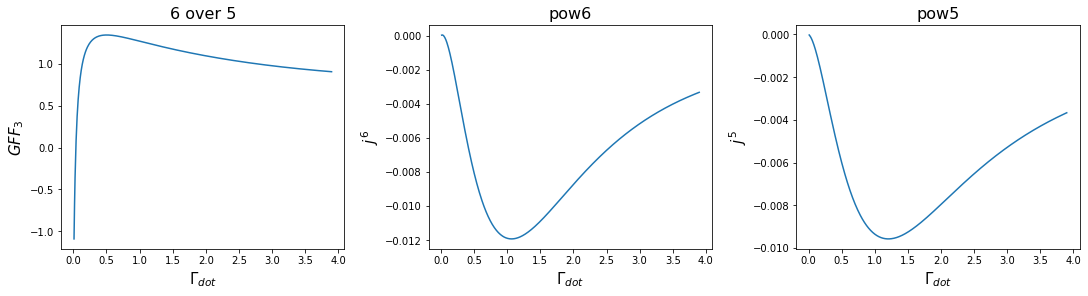

In [ ]:
 fig, ax = plt.subplots(1,3,figsize = (15,4), constrained_layout=True)

ax[0].plot(gamma_axis,y[:,0])
ax[0].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[0].set_ylabel(r'$GFF_3$',fontsize = 15)
ax[0].set_title("6 over 5",fontsize=16)

ax[1].plot(gamma_axis,y[:,2])
ax[1].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[1].set_ylabel(r'$j^6$',fontsize = 15)
ax[1].set_title("pow6",fontsize=16)

ax[2].plot(gamma_axis,y[:,1])
ax[2].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[2].set_ylabel(r'$j^5$',fontsize = 15)
ax[2].set_title("pow5",fontsize=16)

plt.show()

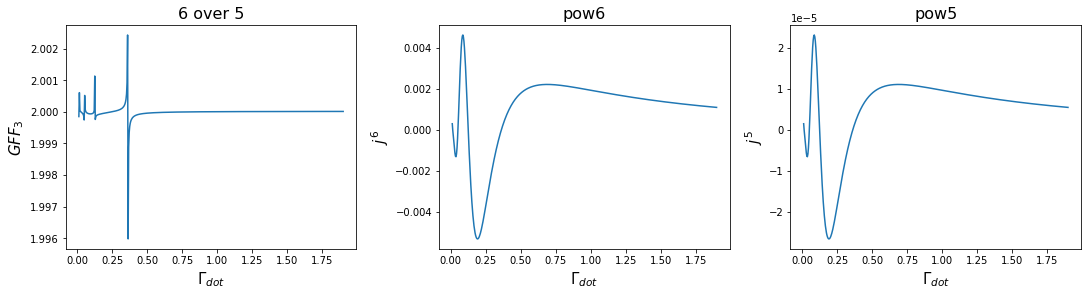

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (15,4), constrained_layout=True)

ax[0].plot(gamma_axis,y3[:,0])
ax[0].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[0].set_ylabel(r'$GFF_3$',fontsize = 15)
ax[0].set_title("6 over 5",fontsize=16)

ax[1].plot(gamma_axis,y3[:,2])
ax[1].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[1].set_ylabel(r'$j^6$',fontsize = 15)
ax[1].set_title("pow6",fontsize=16)

ax[2].plot(gamma_axis,y3[:,1])
ax[2].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[2].set_ylabel(r'$j^5$',fontsize = 15)
ax[2].set_title("pow5",fontsize=16)

plt.show()

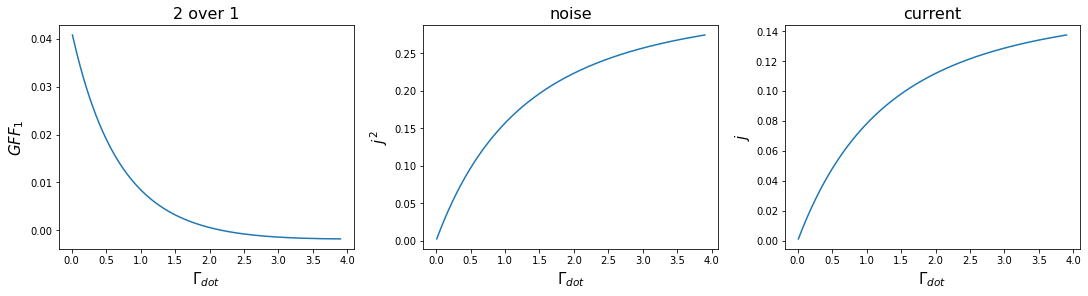

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (15,4), constrained_layout=True)

ax[0].plot(gamma_axis,y[:,3])
ax[0].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[0].set_ylabel(r'$GFF_1$',fontsize = 15)
ax[0].set_title("2 over 1",fontsize=16)

ax[1].plot(gamma_axis,y[:,4])
ax[1].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[1].set_ylabel(r'$j^2$',fontsize = 15)
ax[1].set_title("noise",fontsize=16)

ax[2].plot(gamma_axis,y[:,5])
ax[2].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[2].set_ylabel(r'$j$',fontsize = 15)
ax[2].set_title("current",fontsize=16)

plt.show()

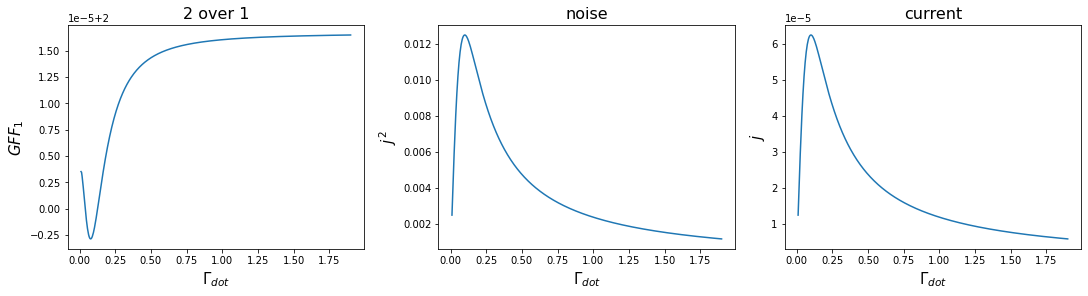

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (15,4), constrained_layout=True)

ax[0].plot(gamma_axis,y3[:,3])
ax[0].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[0].set_ylabel(r'$GFF_1$',fontsize = 15)
ax[0].set_title("2 over 1",fontsize=16)

ax[1].plot(gamma_axis,y3[:,4])
ax[1].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[1].set_ylabel(r'$j^2$',fontsize = 15)
ax[1].set_title("noise",fontsize=16)

ax[2].plot(gamma_axis,y3[:,5])
ax[2].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[2].set_ylabel(r'$j$',fontsize = 15)
ax[2].set_title("current",fontsize=16)

plt.show()

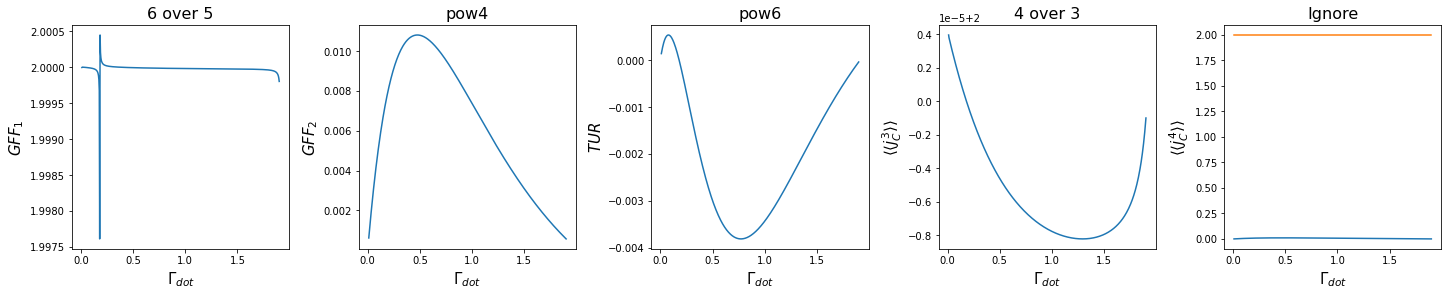

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(eps_axis,y)
# ax.set_ylabel(r'$ratio_{T}$',fontsize = 15)
# ax.set_xlabel(r'$\epsilon_{dot}$',fontsize = 15)
# plt.show()

fig, ax = plt.subplots(1,5,figsize = (20,4), constrained_layout=True)

ax[0].plot(gamma_axis,y[:,0])
ax[0].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[0].set_ylabel(r'$GFF_1$',fontsize = 15)
ax[0].set_title("6 over 5",fontsize=16)

ax[1].plot(gamma_axis,y[:,1])
ax[1].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[1].set_ylabel(r'$GFF_2$',fontsize = 15)
ax[1].set_title("pow4",fontsize=16)

ax[2].plot(gamma_axis,y[:,2])
ax[2].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[2].set_ylabel(r'$TUR$',fontsize = 15)
ax[2].set_title("pow6",fontsize=16)

ax[3].plot(gamma_axis,y[:,3])
ax[3].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[3].set_ylabel(r'$\langle \langle j_C^3 \rangle \rangle$',fontsize = 15)
ax[3].set_title("4 over 3",fontsize=16)

ax[4].plot(gamma_axis,y[:,4])
ax[4].plot(gamma_axis,y[:,3])
ax[4].set_xlabel(r'$\Gamma_{dot}$',fontsize = 15)
ax[4].set_ylabel(r'$\langle \langle j_C^4 \rangle \rangle$',fontsize = 15)
ax[4].set_title("Ignore",fontsize=16)

plt.show() 

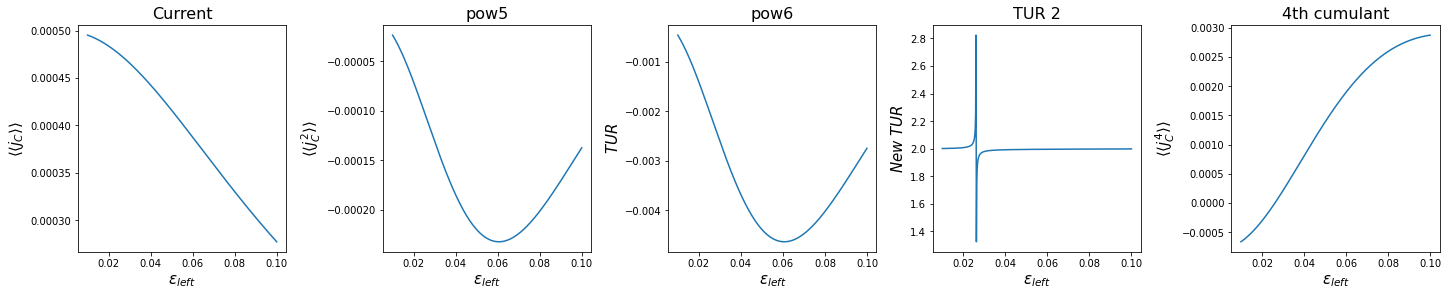

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(eps_axis2,y2)
# ax.set_ylabel(r'$ratio_{T_2}$',fontsize = 15)
# ax.set_xlabel(r'$\epsilon_{left}$',fontsize = 15)
# # plt.savefig("ratio_vs_eps_3.png",dpi=500)
# plt.show()

fig, ax = plt.subplots(1,5,figsize = (20,4), constrained_layout=True)

ax[0].plot(eps_axis2,y2[:,0])
ax[0].set_xlabel(r'$\epsilon_{left}$',fontsize = 15)
ax[0].set_ylabel(r'$\langle \langle j_C \rangle \rangle$',fontsize = 15)
ax[0].set_title("Current",fontsize=16)

ax[1].plot(eps_axis2,y2[:,1])
ax[1].set_xlabel(r'$\epsilon_{left}$',fontsize = 15)
ax[1].set_ylabel(r'$\langle \langle j_C^2 \rangle \rangle$',fontsize = 15)
ax[1].set_title("pow5",fontsize=16)

ax[2].plot(eps_axis2,y2[:,2])
ax[2].set_xlabel(r'$\epsilon_{left}$',fontsize = 15)
ax[2].set_ylabel(r'$TUR$',fontsize = 15)
ax[2].set_title("pow6",fontsize=16)

ax[3].plot(eps_axis2,y2[:,3])
ax[3].set_xlabel(r'$\epsilon_{left}$',fontsize = 15)
ax[3].set_ylabel(r'$New \ TUR$',fontsize = 15)
ax[3].set_title("TUR 2",fontsize=16)

ax[4].plot(eps_axis2,y2[:,4])
ax[4].set_xlabel(r'$\epsilon_{left}$',fontsize = 15)
ax[4].set_ylabel(r'$\langle \langle j_C^4 \rangle \rangle$',fontsize = 15)
ax[4].set_title("4th cumulant",fontsize=16)

# plt.savefig("double-dot.png",dpi=600)
plt.show() 

In [ ]:
# y2[:,4]

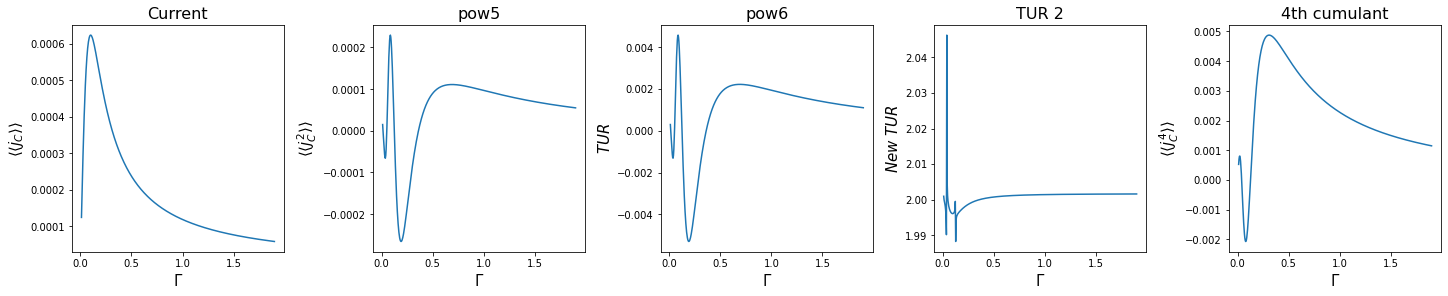

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(omega_axis3,y3)
# ax.set_ylabel(r'$ratio_{T_2}$',fontsize = 15)
# ax.set_xlabel(r'$\Omega$',fontsize = 15)
# # plt.savefig("ratio_vs_omega.png",dpi=500)
# plt.show()

fig, ax = plt.subplots(1,5,figsize = (20,4), constrained_layout=True)

ax[0].plot(gamma_axis,y3[:,0])
ax[0].set_xlabel(r'$\Gamma$',fontsize = 15)
ax[0].set_ylabel(r'$\langle \langle j_C \rangle \rangle$',fontsize = 15)
ax[0].set_title("Current",fontsize=16)

ax[1].plot(gamma_axis,y3[:,1])
ax[1].set_xlabel(r'$\Gamma$',fontsize = 15)
ax[1].set_ylabel(r'$\langle \langle j_C^2 \rangle \rangle$',fontsize = 15)
ax[1].set_title("pow5",fontsize=16)

ax[2].plot(gamma_axis,y3[:,2])
ax[2].set_xlabel(r'$\Gamma$',fontsize = 15)
ax[2].set_ylabel(r'$TUR$',fontsize = 15)
ax[2].set_title("pow6",fontsize=16)

ax[3].plot(gamma_axis,y3[:,3])
ax[3].set_xlabel(r'$\Gamma$',fontsize = 15)
ax[3].set_ylabel(r'$New \ TUR$',fontsize = 15)
ax[3].set_title("TUR 2",fontsize=16)

ax[4].plot(gamma_axis,y3[:,4])
ax[4].set_xlabel(r'$\Gamma$',fontsize = 15)
ax[4].set_ylabel(r'$\langle \langle j_C^4 \rangle \rangle$',fontsize = 15)
ax[4].set_title("4th cumulant",fontsize=16)

plt.show() 

In [ ]:
a = np.zeros((50,3))
a[:,0][49]

0.0